In [47]:
import tensorflow as tf
gpus=tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu,True)

In [48]:
import tensorflow_datasets as tfds      #fashion mnist dataset
from matplotlib import pyplot as plt

In [49]:
ds=tfds.load('fashion_mnist',split='train')

In [50]:
ds.as_numpy_iterator().next().keys()

2023-11-14 16:43:00.266190: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


dict_keys(['image', 'label'])

In [51]:
import numpy as np
dataiterator=ds.as_numpy_iterator()
dataiterator.next()['image'].shape

2023-11-14 16:43:00.276830: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(28, 28, 1)

In [52]:
np.squeeze(dataiterator.next()['image']).shape

(28, 28)

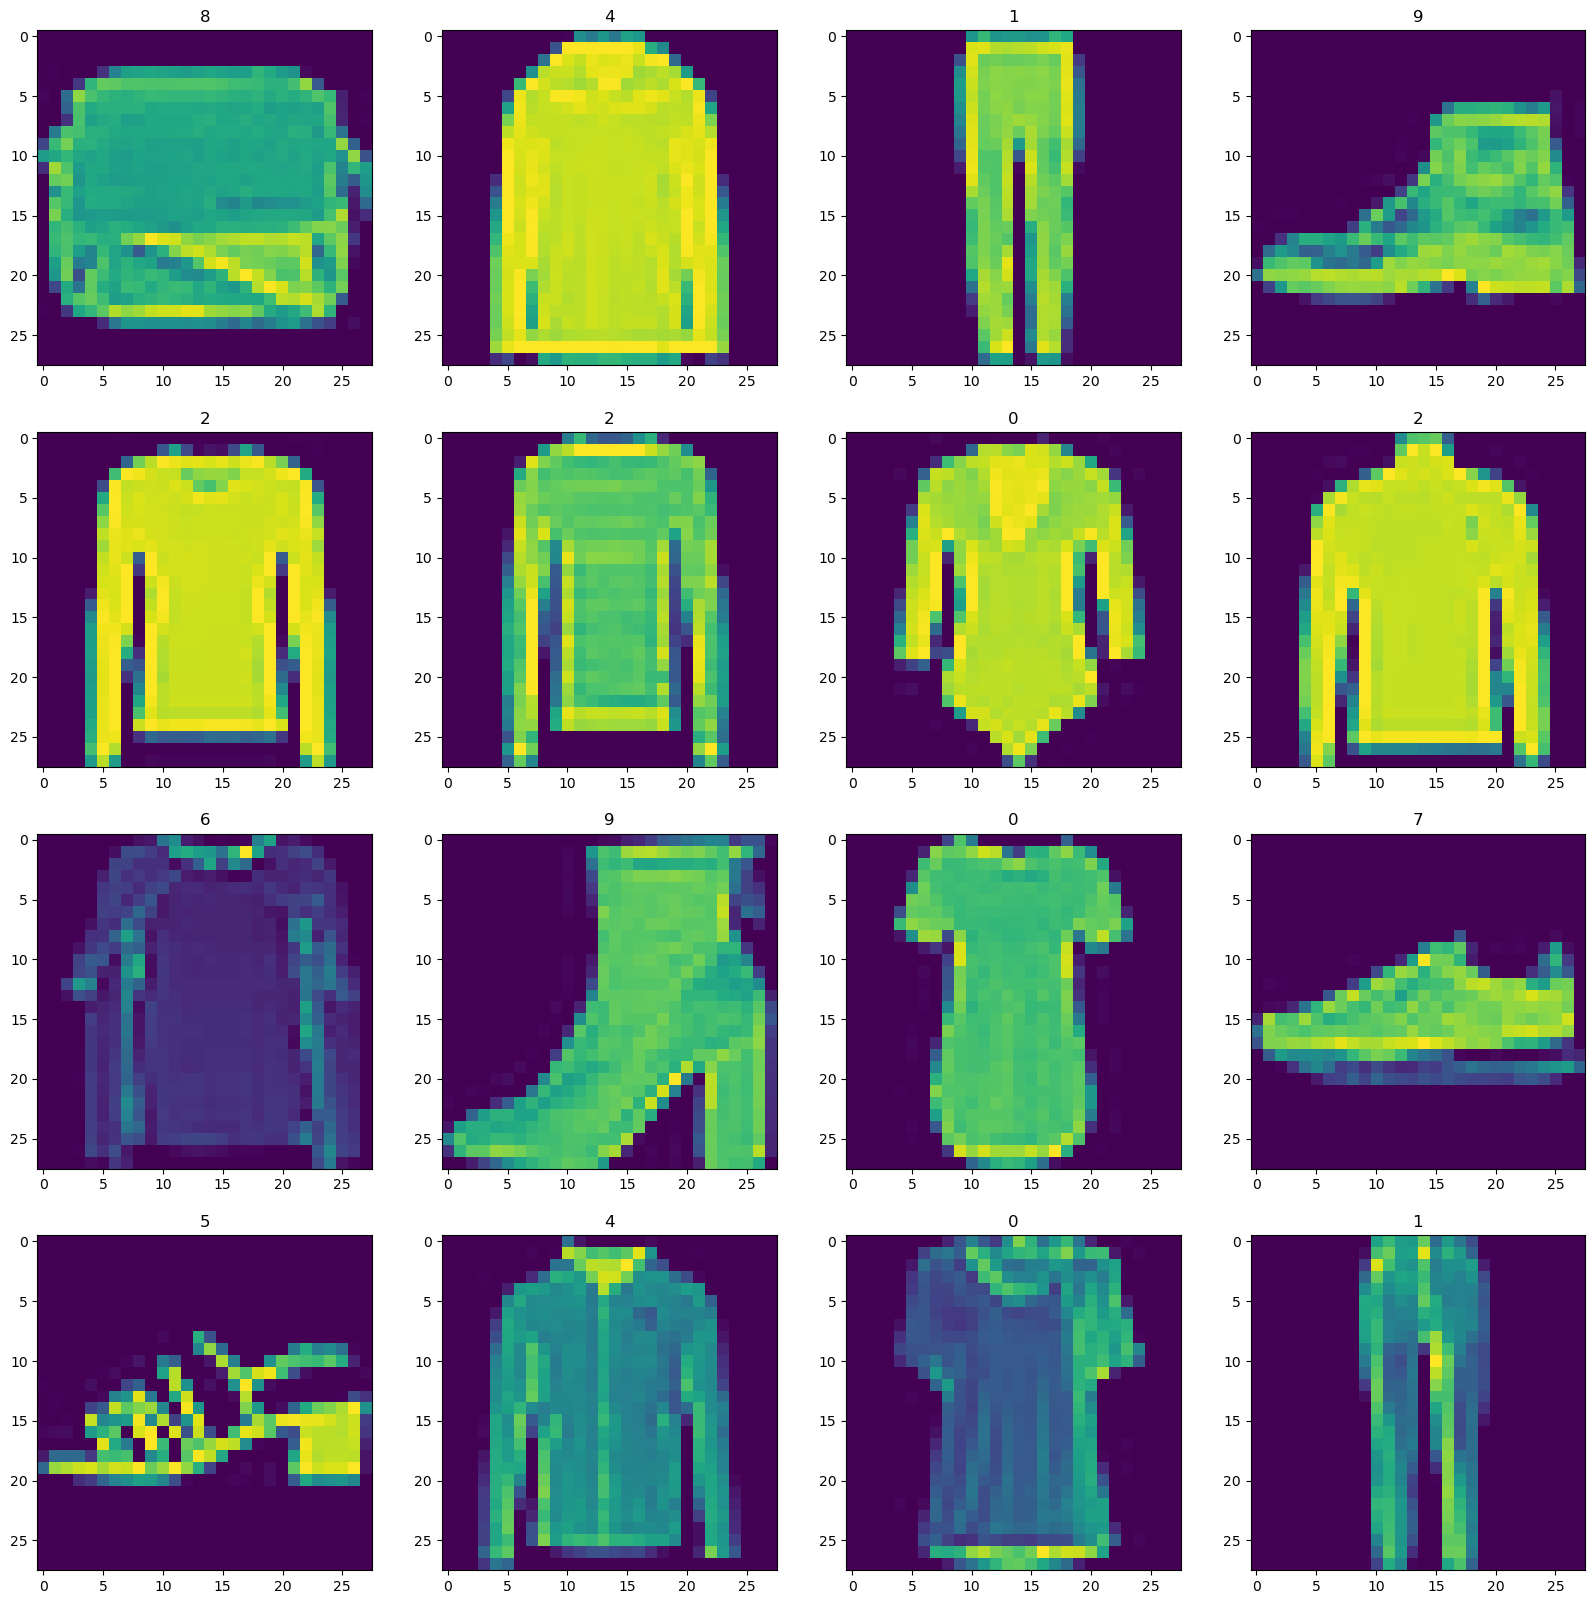

In [53]:
fig,ax =plt.subplots(ncols=4,nrows=4, figsize=(20,20))
for i in range(4):
    for j in range(4):
        
        sample=dataiterator.next()
        ax[i,j].imshow(sample['image'])
        ax[i,j].title.set_text(sample['label'])

In [54]:
def scale_image(data):
    img=data['image']
    return img/255
    

In [55]:
ds=tfds.load('fashion_mnist',split='train')

ds=ds.map(scale_image)
ds=ds.cache()
ds=ds.shuffle(60000)
ds=ds.batch(128)
ds=ds.prefetch(64)

In [56]:
ds.as_numpy_iterator().next().shape    #batched into 128 samples

(128, 28, 28, 1)

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape,LeakyReLU, Dropout, UpSampling2D

In [58]:
def build_generator():
    model=Sequential()
    
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(1,4,padding='same',activation='sigmoid'))
    
    return model

In [59]:
generator=build_generator()

In [60]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [61]:
img=generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 81ms/step


In [62]:
img

array([[[[0.49558988],
         [0.50180227],
         [0.4978716 ],
         ...,
         [0.50801235],
         [0.5015835 ],
         [0.50229204]],

        [[0.49294814],
         [0.49834675],
         [0.49099153],
         ...,
         [0.50773656],
         [0.5001671 ],
         [0.5014399 ]],

        [[0.49083042],
         [0.50229794],
         [0.49890026],
         ...,
         [0.50359255],
         [0.49835995],
         [0.5027521 ]],

        ...,

        [[0.49648985],
         [0.49367234],
         [0.4979516 ],
         ...,
         [0.5039667 ],
         [0.5041046 ],
         [0.504713  ]],

        [[0.49595788],
         [0.4931078 ],
         [0.49553004],
         ...,
         [0.5017716 ],
         [0.5026173 ],
         [0.5010884 ]],

        [[0.4992057 ],
         [0.50017357],
         [0.5005091 ],
         ...,
         [0.50327754],
         [0.502559  ],
         [0.5012495 ]]],


       [[[0.5066877 ],
         [0.50378627],
         [0.50

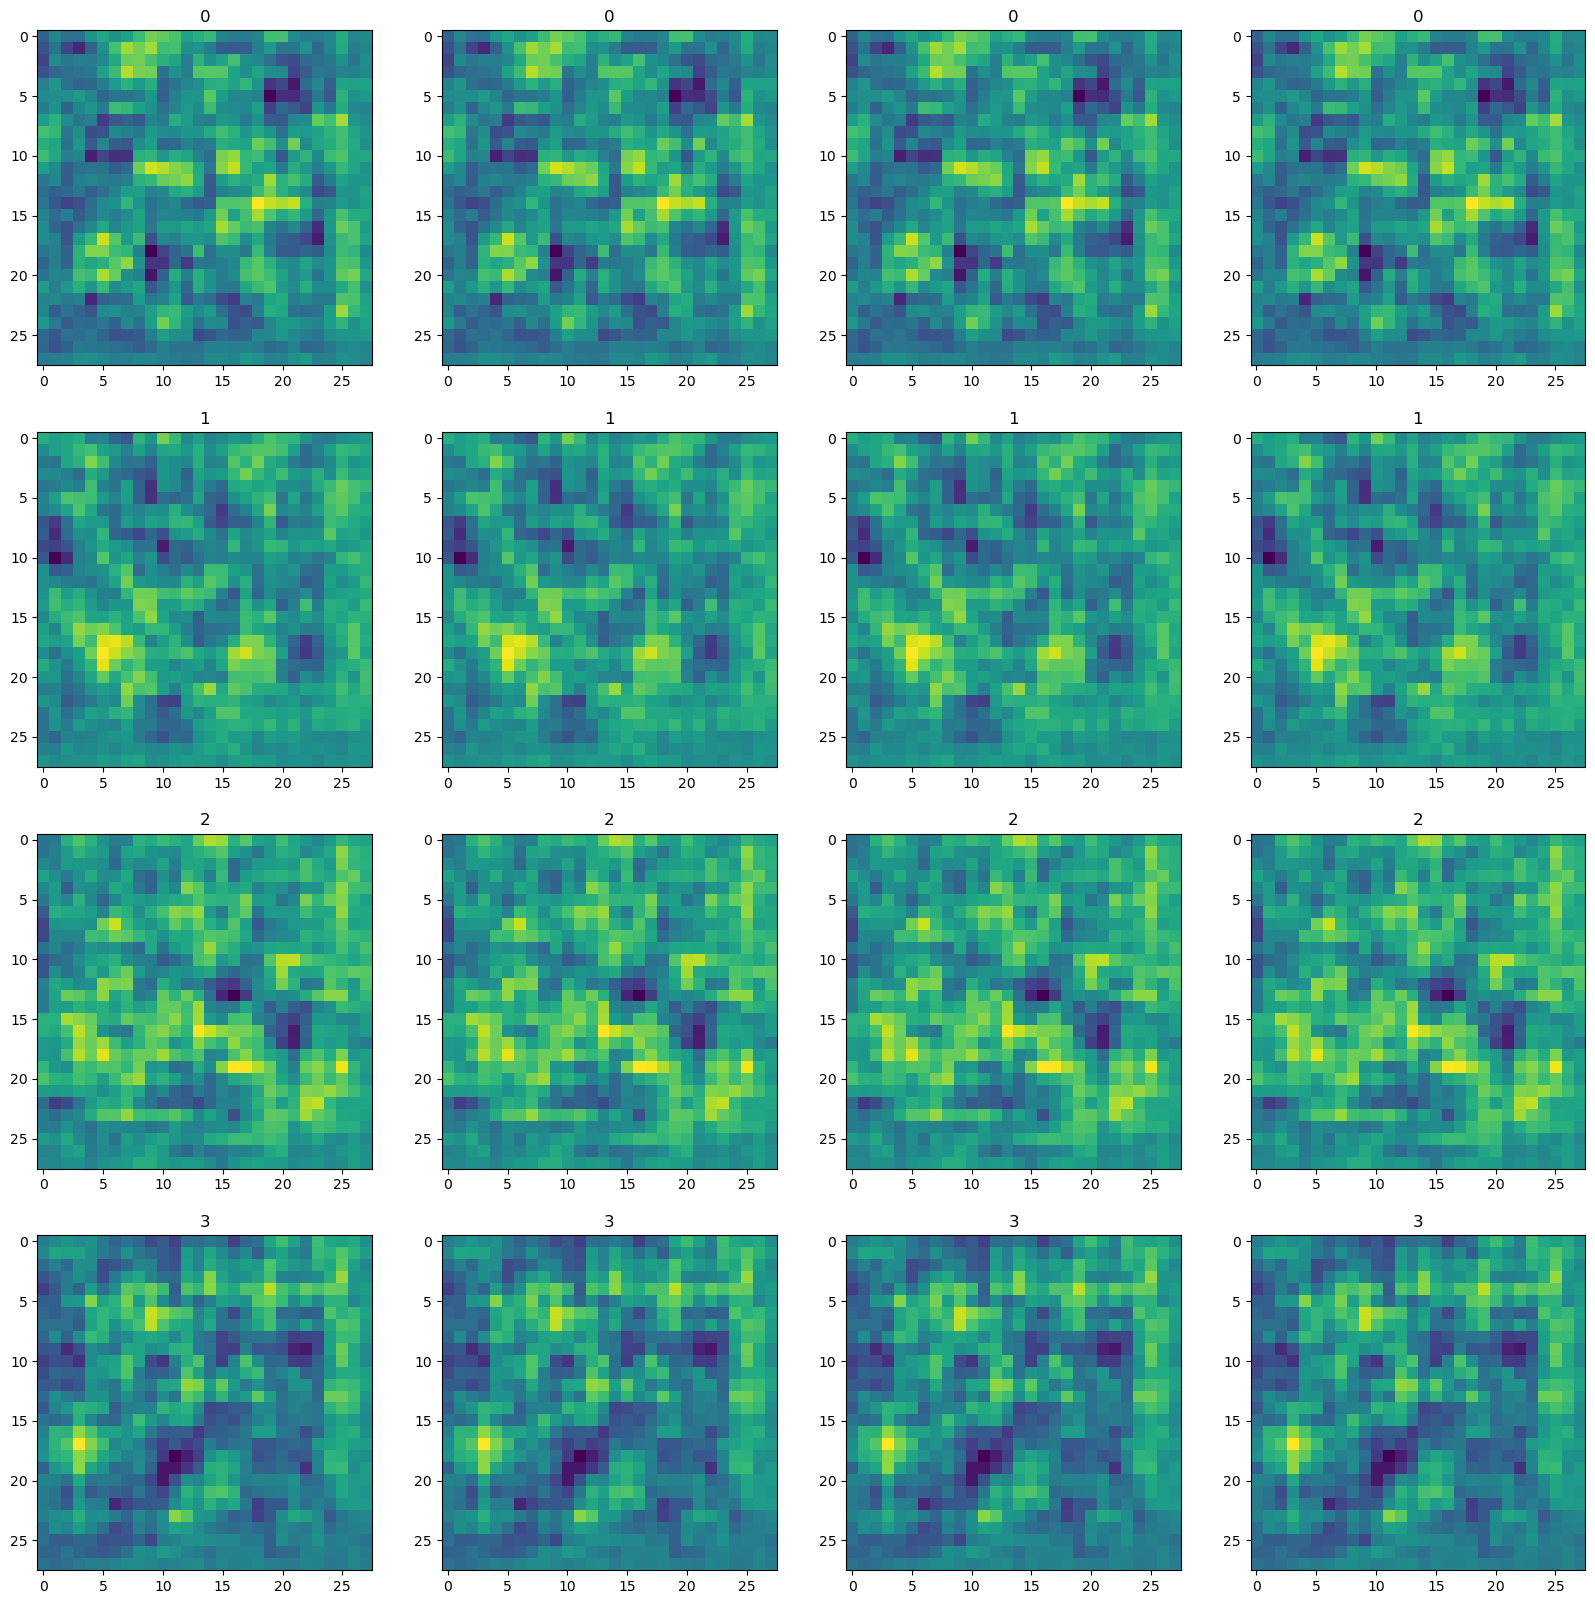

In [63]:
fig,ax =plt.subplots(ncols=4,nrows=4, figsize=(20,20))
for i,img in enumerate(img):
    for j in range(4):
        
        sample=dataiterator.next()
        ax[i,j].imshow(img)
        ax[i,j].title.set_text(i)

In [64]:
def build_discriminator():
    
    model=Sequential();
    
    model.add(Conv2D(32,5,input_shape=(28,28,1)))
    model.add(LeakyReLU(0.3))
    model.add(Dropout(0.6))
    
    model.add(Conv2D(64,5))
    model.add(LeakyReLU(0.3))
    model.add(Dropout(0.6))
    
    model.add(Conv2D(128,5))
    model.add(LeakyReLU(0.3))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(256,5))
    model.add(LeakyReLU(0.3))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation='sigmoid'))
    
    return model
    

In [65]:
discriminator=build_discriminator()

In [66]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)      

In [67]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [68]:
g_opt=Adam(learning_rate=0.0001)
d_opt=Adam(learning_rate=0.00001)
g_loss=BinaryCrossentropy()
d_loss=BinaryCrossentropy()

In [69]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)


            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}




In [70]:
#creating instance/object of subclassed model

fashgan=FashionGAN(generator,discriminator)

In [71]:
#compiling the model
fashgan.compile(g_opt,d_opt,g_loss,d_loss)

In [72]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback



In [73]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [74]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=20,callbacks=[ModelMonitor()])

Epoch 1/20
469/469 [==============================] - 444s 945ms/step - d_loss: 0.5034 - g_loss: 0.9124
Epoch 2/20
379/469 [=======================>......] - ETA: 1:35 - d_loss: 0.6693 - g_loss: 0.6268

KeyboardInterrupt: 

In [80]:
    generator.load_weights(os.path.join('archives','generatormodel.h5'),by_name=True)

In [84]:
imgs=generator.predict(tf.random.normal((16,128,1)))

1/1 [==============================] - 0s 46ms/step


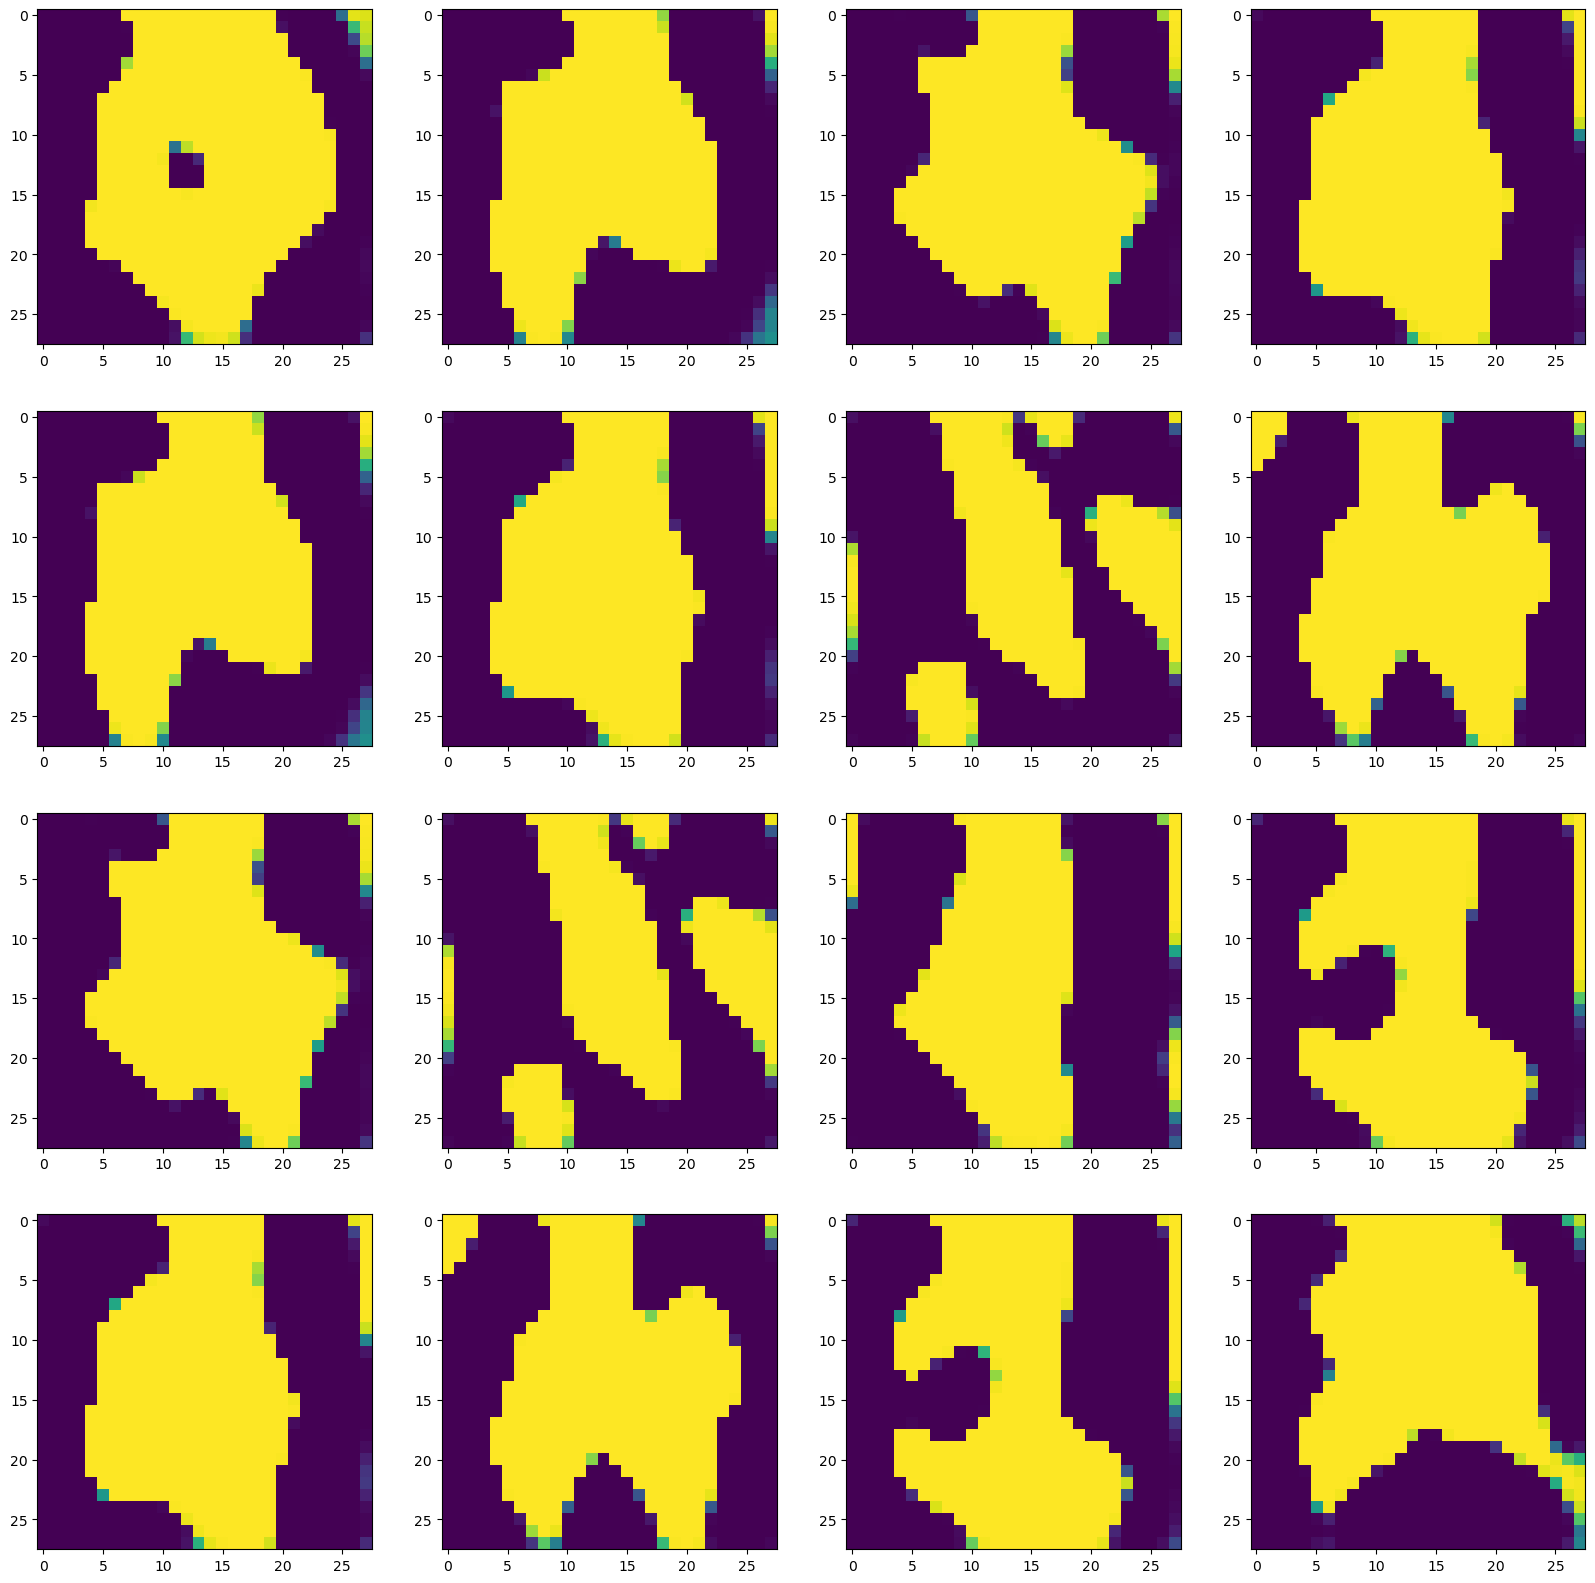

In [85]:
    fig, ax=plt.subplots(ncols=4, nrows=4,figsize=(20,20))
    for i in range(4):
        for j in range(4):
            ax[i][j].imshow(imgs[(i+1)*(j+1)-1])